# Import Needed Packages

In [1]:
#import needed packages

import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
import time
%matplotlib inline

# Markov Chain Time Series Generator + Examples

In [2]:
# P is the (k x k) transition matrix
# S is the vector of averages for each state (of length k)
# sigma is the shared variance
# n is the number of points to generate (length of time series)
# if debug = True, return state_gen rather than time_series.
def mkv_to_ts(P, S, sigma = 1, n = 10000, debug=False):
    k = len(S)
    base_matrix = np.tile(S, (n, 1)).T
    noise_matrix = np.random.normal(0, sigma, (k, n))
    full_matrix = base_matrix + noise_matrix
    
    state_gen = np.empty(n, dtype = np.int32)
    state_gen[0] = 0
    for i in range(1, n):
        state_gen[i] = np.random.choice(k, p=P[state_gen[i-1]])
    return state_gen if debug else np.choose(state_gen, full_matrix)

In [3]:
# define example parameters

P = np.array([[0.95, 0.02, 0.03],
              [0.01, 0.95, 0.04],
              [0.03, 0.03, 0.94]])
    
S = np.array([10, 0, -10])

Text(0, 0.5, 'y_t')

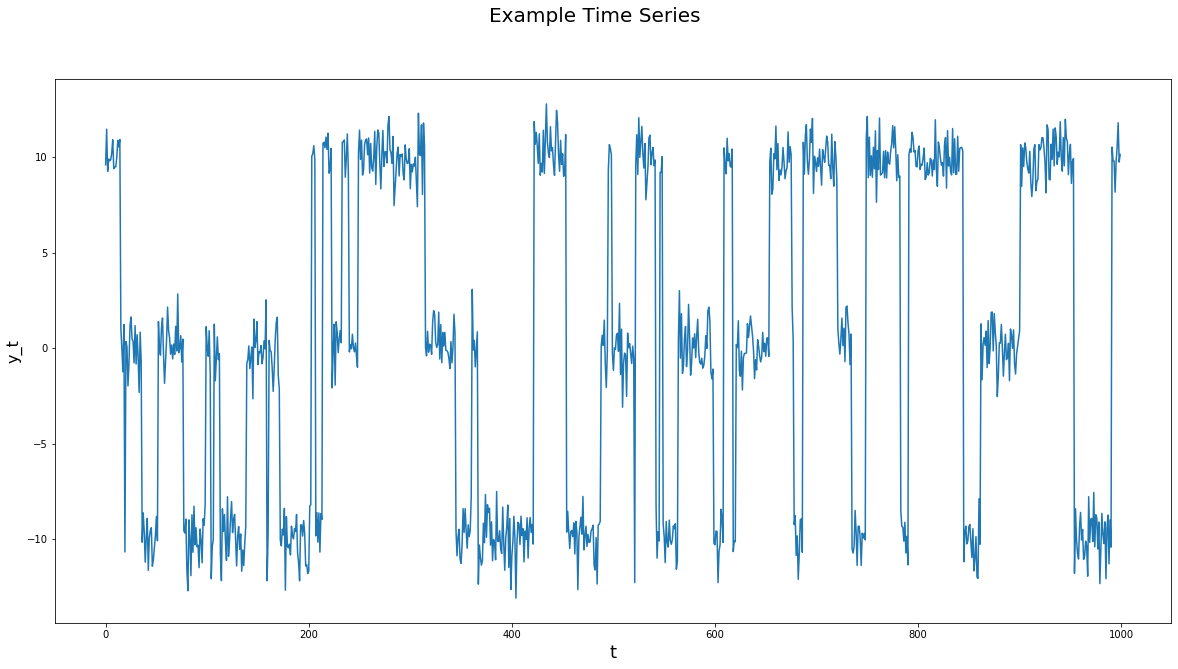

In [4]:
# generate time series and plot
ts = mkv_to_ts(P, S, n=1000)
fig = plt.figure(figsize=(20,10))
plt.plot(ts)
fig.suptitle('Example Time Series', fontsize=20)
plt.xlabel('t', fontsize=18)
plt.ylabel('y_t', fontsize=16)


# Checks that stationary distribution ~ MCTS

In [5]:
# Sanity Check:
# First, find the stationary distribution:

S, U = np.linalg.eig(P.T)
stationary = np.array(U[:, np.where(np.abs(S - 1.) < 1e-8)[0][0]].flat)
stat_dist = stationary / np.sum(stationary)

# Second, print the percent time spent in each state
its = 10 # the number of times the time series are generated

accum = np.zeros_like(stat_dist)
for i in range(its):
    state_gen = mkv_to_ts(P, S, n=10000, debug=True)
    val_counts = np.unique(state_gen, return_counts=True)[1]
    accum += val_counts/np.sum(val_counts)
approx_dist = accum/its

print("Stationary Distribution: " + str(stat_dist))
print("Approx Distribution: " + str(approx_dist))

Stationary Distribution: [0.29032258 0.33870968 0.37096774]
Approx Distribution: [0.28727 0.33209 0.38064]


# Import e_divisive

In [6]:
# pip install git+https://github.com/egoolish/ecp_python
from ecp import e_divisive, e_agglomerative

# Define a MCTS and Run Basic e_divisive

Estimated Number of Change Points: 30.0
Minimum Size before Change: 2
Time:  10.98258376121521
Found Change Points: 19


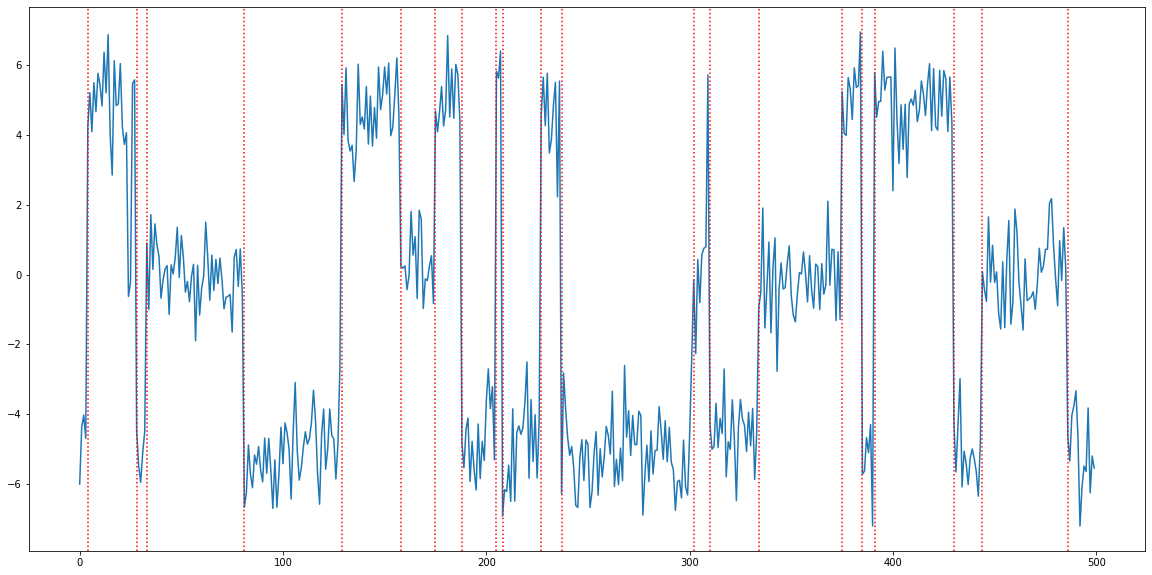

In [38]:
P = np.array([[0.95, 0.02, 0.03],
              [0.01, 0.95, 0.04],
              [0.03, 0.03, 0.94]])
S = np.array([-5, 0, 5])

N = 500
K = int(N/(1/(1 - P[0, 0]))) + N/100
ms = 2
num_of_states = len(S)

ts = mkv_to_ts(P, S, n=N)
plt.figure(figsize=(20,10))
plt.plot(ts)

t1 = time.time()
# sol_dict = e_divisive.e_divisive(X = np.reshape(ts, (len(ts), 1)), k=K, alpha=2, min_size=ms)
sol_dict = e_agglomerative.e_agglo(X = np.reshape(ts, (len(ts), 1)), alpha=2, penalty=lambda x : -500)
t2 = time.time()
print("Estimated Number of Change Points: " + str(K))
print("Minimum Size before Change: " + str(ms))
print("Time: ", t2-t1)
print("Found Change Points: " + str(len(sol_dict['estimates'])-2))
for xc in sol_dict['estimates']:
    plt.axvline(x=xc, color='r', linestyle=':')

For each segment from the initial e_divisive run, finds the mean.

In [39]:
clusters = sol_dict['cluster']
print(len(clusters))
print(sol_dict['estimates'])
print(clusters)
uniq_vals = np.unique(clusters)
num_of_clusters = len(uniq_vals) #clusters[-1]+1

find_means = np.vectorize(lambda x : np.mean(ts[clusters == x]))
cluster_means = find_means(uniq_vals) #find_means(np.arange(num_of_clusters))
print(cluster_means)

500
[  4  28  33  81 129 158 175 188 205 208 227 237 302 310 334 375 385 391
 430 444 486]
[ 0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12

### Sorts the segment means, then runs e_divisive again:
This gives you an idea of how many total clusters there are / which segments are "legit" and which should be merged.

In [40]:
sort_c_idx = np.argsort(cluster_means).argsort()
sort_c = np.sort(cluster_means)

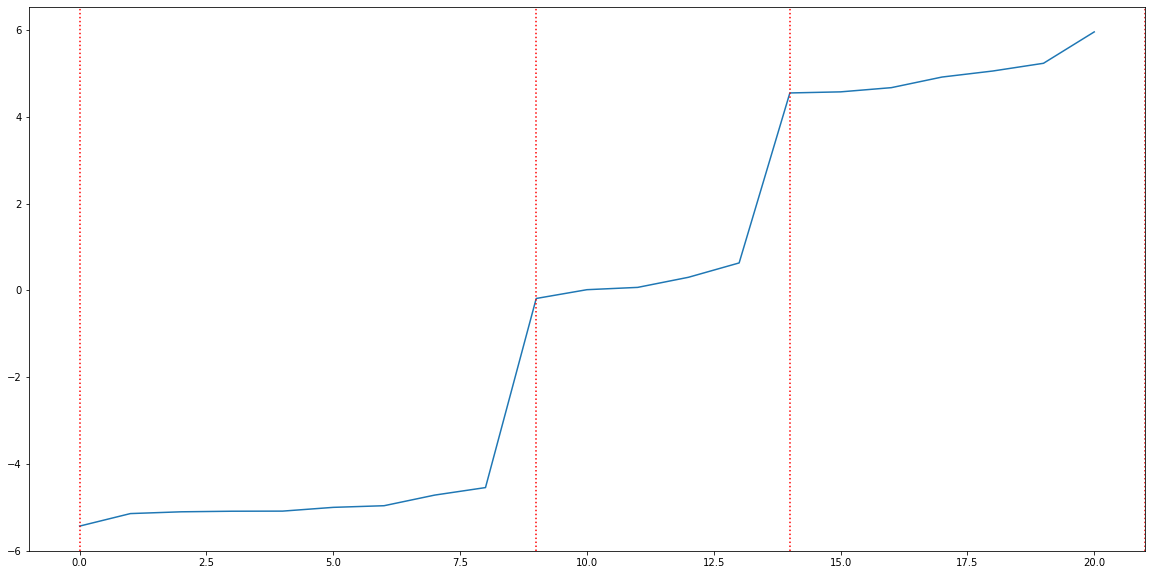

In [41]:
sol_dict_2 = e_divisive.e_divisive(X = np.reshape(sort_c, (len(sort_c), 1)), k=num_of_states-1, alpha=2, min_size=2)
plt.figure(figsize=(20,10))
plt.plot(sort_c)
for xc in sol_dict_2['estimates']:
    plt.axvline(x=xc, color='r', linestyle=':')

### Assigns a cluster label to each initial segment.

In [42]:
cluster_labels = np.zeros(num_of_clusters, dtype=np.int32)
ests = sol_dict_2['estimates']
for i in range(1, len(ests)):
    cluster_labels[(sort_c_idx >= ests[i-1]) & (sort_c_idx < ests[i])] = i - 1

print(cluster_labels)

[0 2 0 1 0 2 1 2 0 2 0 2 0 1 0 1 2 0 2 0 1]


### Prints initial segment splits, then uses the above labels to propose new segment splits:
Idea: if two adjacent segments have the same label, then remove their segment split from the list.

In [51]:
print(sol_dict['estimates'])
new_ests = [sol_dict['estimates'][0]]
new_labs = [cluster_labels[0]]
for i in range(1, len(cluster_labels)):
    if cluster_labels[i] != cluster_labels[i-1]:
        new_ests.append(sol_dict['estimates'][i])
        new_labs.append(cluster_labels[i])
# new_ests.append(sol_dict['estimates'][-1])
final_ests = np.array(new_ests)
new_labs = np.array(new_labs)
print(final_ests)

[  4  28  33  81 129 158 175 188 205 208 227 237 302 310 334 375 385 391
 430 444 486]
[  4  28  33  81 129 158 175 188 205 208 227 237 302 310 334 375 385 391
 430 444 486]


## Plots Merged Segments

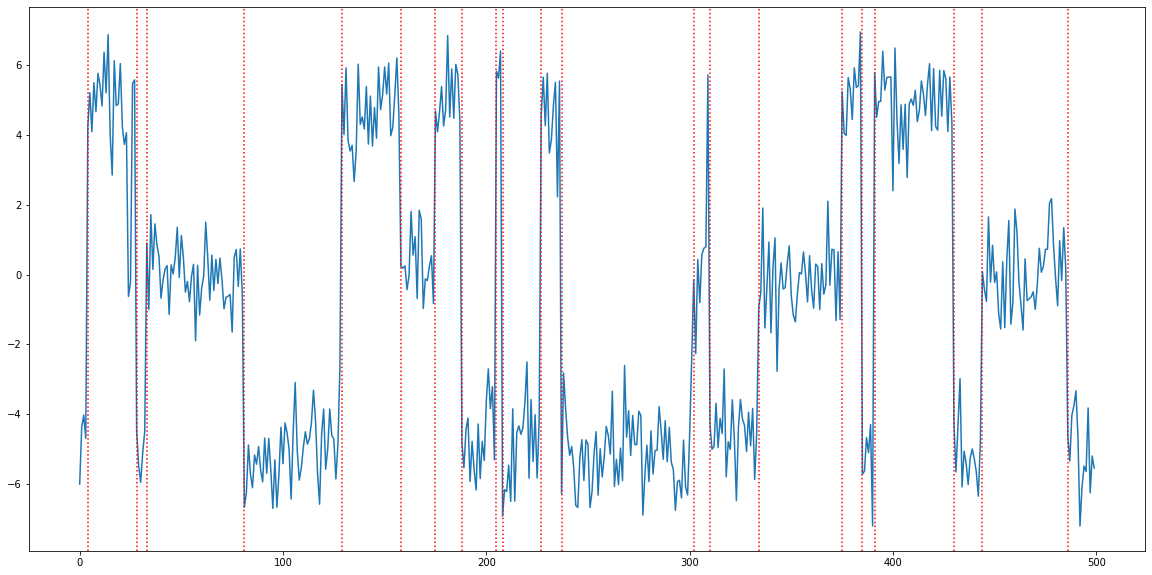

In [52]:
plt.figure(figsize=(20,10))
plt.plot(ts)
for xc in final_ests:
    plt.axvline(x=xc, color='r', linestyle=':')

avg_time: for each state, find the length of an average stay in that state.

Use this to calculate P_{i, i} -- the probability of staying in the same state. This is P_diag

In [53]:
lens = np.diff(final_ests)
find_avg_time = np.vectorize(lambda x : np.mean(lens[new_labs == x]))
avg_times = find_avg_time(np.arange(num_of_states))

print(avg_times) #P_{i, i} = (x - 1)/x
P_diag = np.vectorize(lambda x : (x - 1)/x)(avg_times)
print(P_diag)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 20 but corresponding boolean dimension is 21

Count the total number of times we go from a state i to any other state.

Also count the number of times we go from a state i to a specific state j.

P_{i, j} is proportional to (# of times we go from i to j)/(# of times we go from i to any other state).

To calculate P_{i, j} exactly, see how much wiggle room we have (1 - P_{i, i}). Then fill up that wiggle room with a normalized version of the above ratio.

In [46]:
est_P = np.zeros((num_of_states, num_of_states))
for i in range(1, len(cluster_labels)):
    est_P[cluster_labels[i-1], cluster_labels[i]] += 1
np.fill_diagonal(est_P, 0)
est_P = normalize(est_P, axis = 1, norm='l1')
est_P = (est_P.T*(1 - P_diag)).T
np.fill_diagonal(est_P, P_diag)
print(est_P)

[[0.96311475 0.01639344 0.0204918 ]
 [0.02631579 0.94736842 0.02631579]
 [0.04195804 0.00699301 0.95104895]]


# Updates cluster labels, then for each label, finds its average across all visits.

In [50]:
print(final_ests)
final_clusters = np.repeat(np.arange(0,len(np.diff(final_ests))), np.diff(final_ests))
print(len(final_clusters))
print(len(ts))
find_seg_sums = np.vectorize(lambda x : np.sum(ts[final_clusters == x]))
seg_sums = find_seg_sums(np.arange(final_clusters[-1]+1))

find_time = np.vectorize(lambda x: np.sum(lens[new_labs == x]))
total_times = find_time(np.arange(num_of_states))

find_state_sums = np.vectorize(lambda x: np.sum(seg_sums[new_labs == x]))
est_S = find_state_sums(np.arange(num_of_states))/total_times
print(est_S)

[  4  28  33  81 129 158 175 188 205 208 227 237 302 310 334 375 385 391
 430 444 486 486]
482
500


IndexError: boolean index did not match indexed array along dimension 0; dimension is 500 but corresponding boolean dimension is 482

# Prints Comparison between Actual/Estimated P and S

In [ ]:
#Final Solution:
plt.figure(figsize=(20,10))
plt.plot(ts)
for xc in final_ests:
    plt.axvline(x=xc, color='r', linestyle=':')
    
print("Actual P: ")
print(P)
print("Estimated P: ")
print(est_P)
print()
print("Actual S: ")
print(S)
print("Estimated S: ")
print(est_S)

### Generates a home state time series (The chain travels occasionally to unique other states, but always returns to a home state)

In [ ]:
def return_state_ts(hs_mean=0, hs_stay_p = 0.995, away_stay_p = 0.99, sigma = 1, n = 1000):
    ts = np.zeros(n)
    in_hs = True
    
    away_low = 5
    away_high = 15
    
    away_mean = np.random.uniform(away_low, away_high)
    for i in range(n):
        noise = np.random.normal(0, sigma)
        if in_hs:
            ts[i] = hs_mean + noise
            if np.random.uniform(0, 1) > hs_stay_p:
                in_hs = False
                away_mean = np.random.uniform(away_low, away_high)
        else:
            ts[i] = away_mean + noise
            if np.random.uniform(0, 1) > away_stay_p:
                in_hs = True
    return ts

### Plots an example of the home state time series

In [ ]:
ts = return_state_ts(n=5000)
fig = plt.figure(figsize=(20,10))
plt.plot(ts)
fig.suptitle('Home State Time Series', fontsize=20)
plt.xlabel('t', fontsize=18)
plt.ylabel('y_t', fontsize=16)


### Runs e_divisive on an example of the home_state time series

In [ ]:
stay_home_P = 0.995
home_mean = 0
noise = 1

N = 2000
K = int(N/(1/(1 - stay_home_P))) + N/100
ms = 2

ts = return_state_ts(hs_mean = home_mean, hs_stay_p = stay_home_P, sigma = noise, n = N)
plt.figure(figsize=(20,10))
plt.plot(ts)

t1 = time.time()
sol_dict = e_divisive.e_divisive(X = np.reshape(ts, (len(ts), 1)), k=K, alpha=2, min_size=ms)
t2 = time.time()
print("Estimated Number of Change Points: " + str(K))
print("Minimum Size before Change: " + str(ms))
print("Time: ", t2-t1)
print("Found Change Points: " + str(len(sol_dict['estimates'])-2))
for xc in sol_dict['estimates']:
    plt.axvline(x=xc, color='r', linestyle=':')